In [1]:
from tensorflow.keras import models, layers, losses, optimizers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from scipy.io import wavfile
import os

## 데이터 읽기 및 sec초 단위로 자르기

In [2]:
path = 'data/'
files = [[], []]
folder = os.listdir(path)

for piano, syth in zip(os.listdir(path + folder[0]),  os.listdir(path+folder[1])):
    fn = [piano, syth]
    for i in range(2):
        samplerate, file = wavfile.read(path + folder[i] +'/' + fn[i])
        files[i].append(np.array(file, dtype=float))

In [3]:
data = [[], []]
sec = 4 * samplerate

for k in range(2):
    for f in files[k]:
        for i in range(0, f.shape[0] - sec, sec):
            data[k].append(f[i:i + sec, :])

piano, synth = np.array(data)
input_size = (piano.shape[1], piano.shape[2])

In [4]:
input_size

(176400, 2)

# Gan 모델 생성

In [5]:
def Generator():
    inputs = layers.Input(shape=input_size)

    out = layers.Conv1D(filters=32, kernel_size=2, strides=1, padding='same', activation='relu')(inputs)
    out = layers.Conv1D(filters=64, kernel_size=2, strides=2, padding='same', activation='relu')(out)
    out = layers.Conv1D(filters=32, kernel_size=2, strides=4, padding='same', activation='relu')(out)
    out = layers.Conv1D(filters=2, kernel_size=2, strides=8, padding='same', activation='relu')(out)

    out = layers.Reshape((2, out.shape[1]))(out)
    out = layers.Dense(input_size[0], activation='relu')(out)
    out = layers.Reshape(input_size)(out)

    model = models.Model(inputs, out)
    model.compile(optimizer=optimizers.Adam(lr=1e-3), loss=losses.binary_crossentropy, metrics=['binary_crossentropy'])
    
    return model

In [6]:
def discriminator():
    inputs = layers.Input(shape=input_size)
    
    out = layers.Conv1D(filters=32, kernel_size=2, strides=1, padding='same', activation='relu')(inputs)
    out = layers.Conv1D(filters=64, kernel_size=2, strides=2, padding='same', activation='relu')(out)
    out = layers.Conv1D(filters=32, kernel_size=2, strides=4, padding='same', activation='relu')(out)
    out = layers.Conv1D(filters=16, kernel_size=2, strides=8, padding='same', activation='relu')(out)
    out = layers.Conv1D(filters=8, kernel_size=2, strides=16, padding='same', activation='relu')(out)

    out = layers.Flatten()(out)
    out = layers.Dense(1, activation='sigmoid')(out)
    
    model = models.Model(inputs, out)
    model.compile(optimizer=optimizers.Adam(lr=1e-3), loss=losses.binary_crossentropy, metrics=['binary_crossentropy'])
    
    return model

In [7]:
def Gan(discriminator, generator):
    discriminator.trainable=False
    
    inputs = layers.Input(shape=input_size)
    x = generator(inputs)

    out = discriminator(x)
    
    gan = models.Model(inputs, out)
    gan.compile(optimizer=optimizers.Adam(lr=1e-3), loss=losses.binary_crossentropy)
    return gan

# 데이터 분리

In [8]:
x_train, y_train = piano, synth
# x_train, x_test, y_train, y_test = train_test_split(piano, synth, test_size=0.4)

In [17]:
epochs=10
batch_size = 10
gan_losses = list()

In [9]:
# Creating GAN
generator = Generator()
discriminator = discriminator()
gan = Gan(discriminator, generator)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
(?, 176400, 2)
(?, 176400, 2)


In [10]:
for e in range(1,epochs+1):
    print("Epoch %d" %e)
    batch_loss = 0
    for i in range(0, x_train.shape[0] - batch_size, batch_size):
        # Generate random noise as an input to initialize the generator
        # noise = np.random.normal(0,1, [batch_size, 100])
        x = x_train[i:i+batch_size, :, :]
        y = y_train[i:i+batch_size, :, :]

        # Generate fake MNIST images from noised input
        generated_synth = generator.predict(x)

        # Get a random set of  real images
        synth_batch =y[np.random.randint(low=0,high=x.shape[0],size=batch_size), :, :]

        # Construct different batches of real and fake data 
        X = np.concatenate([synth_batch, generated_synth])

        # Labels for generated and real data
        y_dis=np.zeros(2*batch_size)
        y_dis[:batch_size]=1

        # Pretrain discriminator on  fake and real data before starting the gan. 
        discriminator.trainable=True
        
        discriminator.train_on_batch(X, y_dis)

        # Tricking the noised input of the Generator as real data
        y_gen = np.ones(batch_size)

        # During the training of gan, the weights of discriminator should be fixed. 
        # We can enforce that by setting the trainable flag
        discriminator.trainable=False

        # Training  the GAN by alternating the training of the Discriminator and training the chained GAN model with Discriminator's weights freezed.
        loss = gan.train_on_batch(x, y_gen)
        
        batch_loss += loss
        break
    gan_losses.append(loss)
    break

Epoch 1


## 학습 시각화

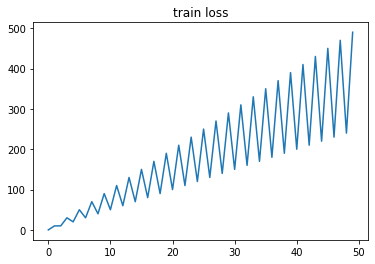

In [28]:
plt.title("train loss")
plt.plot(list(range(len(gan_losses))), gan_losses)
plt.show()

In [ ]:
sample_count = 3
path = './test'

if not os.isdir(path):
    os.mkdir(path)

sample = np.random.randint(0, x_train.shape[0] - sample_count)
test = x_train[sample:sample + sample_count, : , :]

generated_synth = generator.predict(test)

for i in range(sample_count):
    wavfile.write(paht + 'test'+str(i)+'.wav', samplerate, generated_synth[i].T)